<a href="https://colab.research.google.com/github/AliceKitchkin/Forecasting-Rossmann-Store-Sales/blob/main/Forecasting_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vorhersagen von Rossmann Store Sales

## Inhaltsverzeichnis <a id="0"></a> <br>
* [Einleitung](#1)
* [Package- und Datenimport](#2)
* [Deskriptive Analyse](#3)
    * [Allgemeines](#3.1)
    * [Datentypen und Wertebereiche](#3.2)
    * [Korrelationen](#3.3)
* [Geeignete Merkmale](#4)
* [ML Verfahren 1](#5)
    * [XXX](#5.1)
    * [Modellgüte](#5.2)
* [ML Verfahren 2](#6)
* [Vergleich](#7)

## 1. Einleitung <a id="1"></a> <br>

Datenquelle: [kaggle.com](https://www.kaggle.com/competitions/rossmann-store-sales/overview), Ziel dieses Notebooks (Aufgabenstellung) erläutern

## 2. Package- und Datenimport <a id="2"></a> <br>

In [201]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white') # Hintergrund der Plots

Alle Daten werden importiert und die Spalten werden sinngemäß übersetzt.

In [202]:
# unzip train-file, to large for github
# train.csv is included in .gitignore
with zipfile.ZipFile("./data/train.zip", "r") as zip:
    zip.extract('train.csv', "./data/")

train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",
                                                        "DayOfWeek":"Wochentag",
                                                        "Date":"Datum",
                                                        "Sales":"Umsatz",
                                                        "Customers":"Kundenanzahl",
                                                        "Open":"Geoeffnet",
                                                        "Promo":"Aktionstag",
                                                        "StateHoliday":"Feiertag",
                                                        "SchoolHoliday":"Schulferien"})

test_original = pd.read_csv("./data/test.csv").rename(columns={"Id":"ID",
                                                      "Store":"Filiale",
                                                      "DayOfWeek":"Wochentag",
                                                      "Date":"Datum",
                                                      "Open":"Geoeffnet",
                                                      "Promo":"Aktionstag",
                                                      "StateHoliday":"Feiertag",
                                                      "SchoolHoliday":"Schulferien"})

store_original = pd.read_csv("./data/store.csv").rename(columns={"Store":"Filiale",
                                                        "StoreType":"Filialentyp",
                                                        "Assortment":"Sortiment",
                                                        "CompetitionDistance":"Wettbewerberentfernung",
                                                        "CompetitionOpenSinceMonth":"Wettbewerber_Eroeffnet_seit_Monat",
                                                        "CompetitionOpenSinceYear":"Wettbewerber_Eroeffnet_seit_Jahr",
                                                        "Promo2": "Teilnahme_Langzeitaktion",
                                                        "Promo2SinceWeek":"Aktion_seit_Woche",
                                                        "Promo2SinceYear":"Aktion_seit_Jahr",
                                                        "PromoInterval":"Aktionsmonate"})

C:\Users\AliceKitchkin\AppData\Local\Temp\ipykernel_11208\2848156393.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",


Um in einem späteren Zeitpunkt auf die originalen Datensätze zugreifen zu können, werden diese hier separat gespeichert. Außerdem werden die Datensätze _train_original_ und _store_original_ über die Spalte _Filiale_ verbunden und im neuen Datensatz _train_x_store_ gespeichert. Für den Datensatz _test_original_ wird das gleiche Prozedere angewandt.

In [203]:
train = train_original
test = test_original
store = store_original

train_x_store = pd.merge(train, store)
test_x_store = pd.merge(test, store)

## 3. Deskriptive Analyse <a id="3"></a> <br>

### 3.1 Allgemeines <a id="3.1"></a> <br>

Was beschreiben die Daten, fehlen Daten, gibt es falsche Werte, . Was können wir aus dieser deskriptiven Analyse über das Problem lernen?

- Was zeigt der Train-Datensatz?
- Was zeigt der Test-Datensatz?
- Was zeigt der Store-Datensatz?

Um ein ersten Gefühl für die Daten zu bekommen, werden im ersten Schritt die ersten fünf Zeilen jedes Datensatzen ausgegeben. Dabei fällt auf, dass sich der Test-Datensatz in den Spalten zum Train-Datensatz unterscheidet. Die Spalte "ID" existiert im Train-Datensatz nicht und die Spalten "Umsatz" und "Kundenanzahl" fehlen im Test-Datensatz. Das fehlen der "Umsatz" Spalte lässt sich damit erklären, dass das Ziel dieser Ausarbeitung die Vorhersage dieser Werte ist.
- Warum fehlt die Spalte Kundenanzahl?

- in den Spalten Aktion_seit_Woche und Aktion_seit_Jahr fehlen Werte, wenn in der Spalte Teilnahme_Langzeitaktion eine 0 eintragen wurde. Die fehlenden werte sollte durch eine 0 ersetzt werden (?)

Desweiteren fällt auf, dass die Spalte "Aktionsmonate" im Store-Datensatz noch überarbeitet werden muss. In dieser Spalte werden die Aktionsmonate mit einem Komma separiert aufgelistet, was für die Vorhersageverfahren im Anschluss schwierig zu verarbeiten ist.

In [204]:
print("\nTrain-Datensatz (joined mit Store)")
display(train.head())

print("\nTest-Datensatz (joined mit Store)")
display(test.head())

print("\nStore-Datensatz")
display(store_original.head())


Train-Datensatz (joined mit Store)


,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1



Test-Datensatz (joined mit Store)


,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0



Store-Datensatz


,Filiale,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


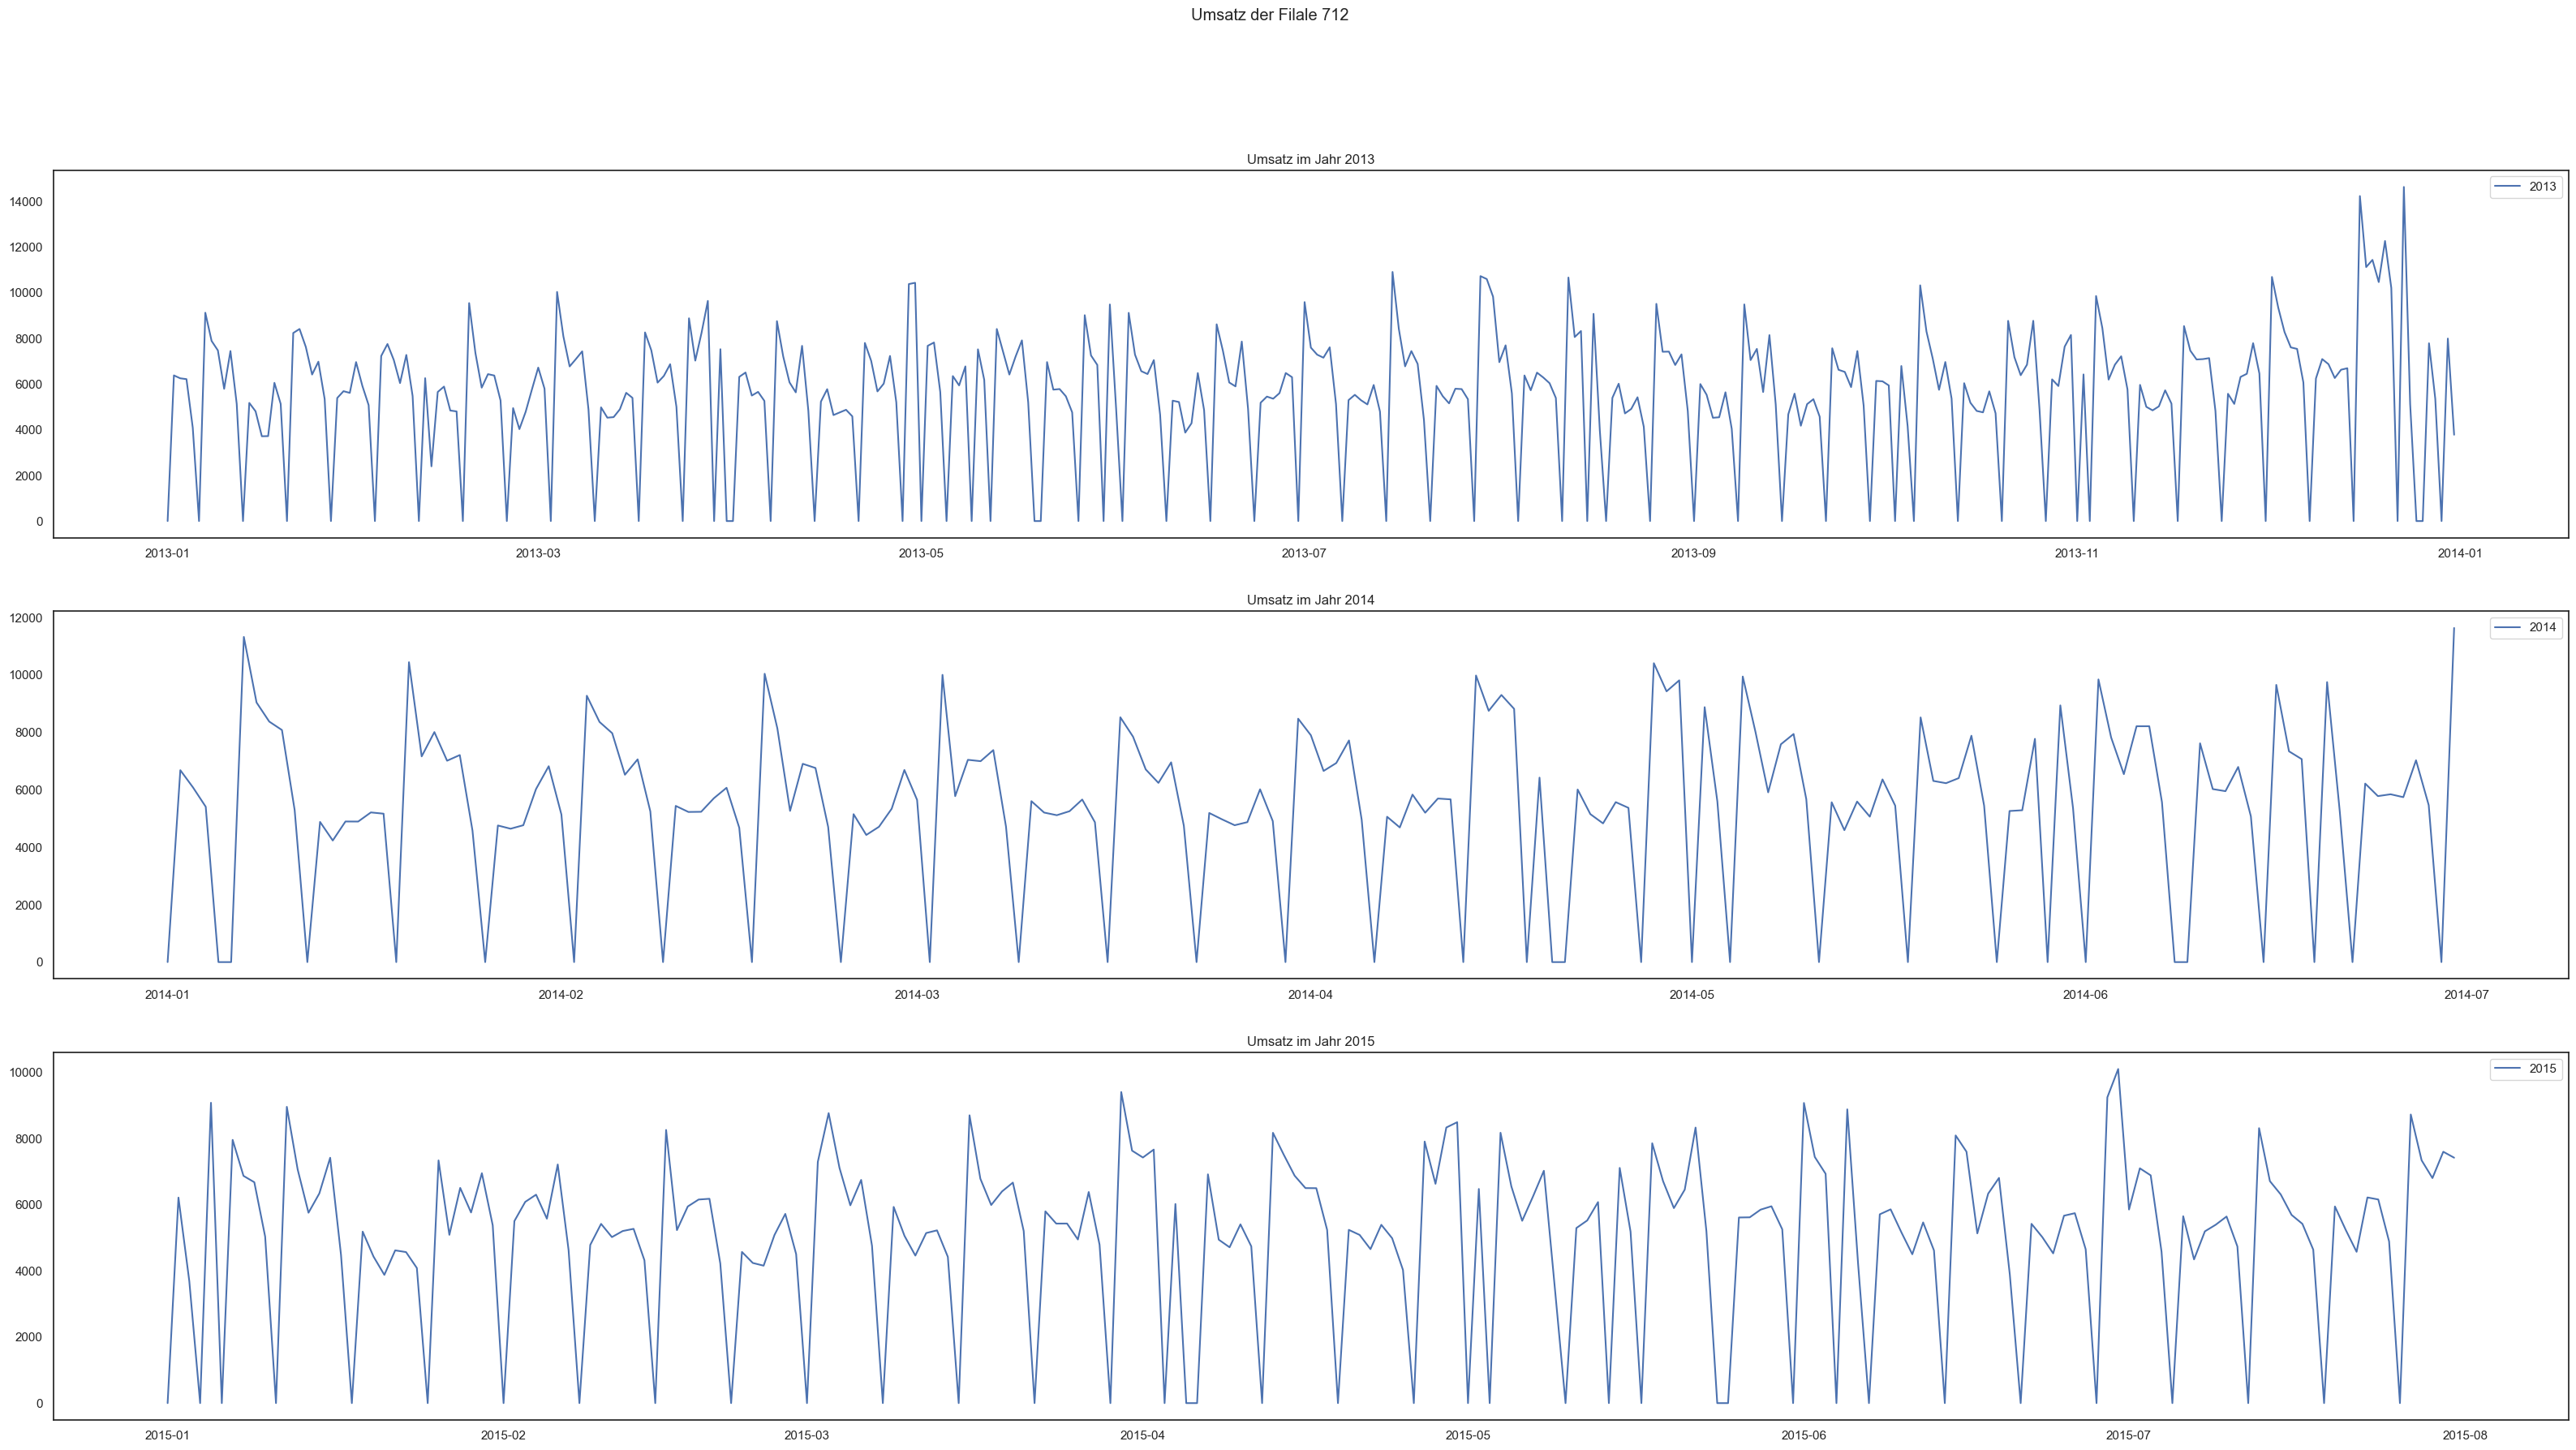

In [205]:
store_id = store["Filiale"].sample(n=1).values[0]
sample = train[train["Filiale"]==store_id].copy()
sample["Datum"] = pd.to_datetime(sample["Datum"])
gp_sample_by_year = sample.groupby(sample["Datum"].dt.year)


fig, axs = plt.subplots(3)
fig.set(figheight = 20, figwidth = 40)
fig.suptitle(f"Umsatz der Filale {store_id}")

for id, sample_year in enumerate(gp_sample_by_year):
    axs[id].plot(sample_year[1]["Datum"], sample_year[1]["Umsatz"], label = sample_year[0])
    axs[id].set_title(f"Umsatz im Jahr {sample_year[0]}")
    axs[id].legend()

plt.show()

### 3.2 Datentypen und Wertebereiche <a id="3.2"></a> <br>

#### 3.2.1 Analyse <a id="3.2.1"></a> <br>

Machen alle Datentypen sinn? Welche sollte man ändern und wieso? Wertebereiche?

In [206]:
print("Train-Datensatz")
describe = train.describe(include='all')
dtypes = pd.DataFrame(train.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

print("\nTest-Datensatz")
describe = test.describe(include='all')
dtypes = pd.DataFrame(test.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

print("\nStore-Datensatz")
describe = store.describe(include='all')
dtypes = pd.DataFrame(store.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

Train-Datensatz


,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
dtypes,int64,int64,object,int64,int64,int64,int64,object,int64
count,1017209.0,1017209.0,1017209,1017209.0,1017209.0,1017209.0,1017209.0,1017209,1017209.0
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN
top,NaN,NaN,2015-07-31,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN
mean,558.429727,3.998341,NaN,5773.818972,633.145946,0.830107,0.381515,NaN,0.178647
std,321.908651,1.997391,NaN,3849.926175,464.411734,0.375539,0.485759,NaN,0.383056
min,1.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
25%,280.0,2.0,NaN,3727.0,405.0,1.0,0.0,NaN,0.0
50%,558.0,4.0,NaN,5744.0,609.0,1.0,0.0,NaN,0.0



Test-Datensatz


,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien
dtypes,int64,int64,int64,object,float64,int64,object,int64
count,41088.0,41088.0,41088.0,41088,41077.0,41088.0,41088,41088.0
unique,NaN,NaN,NaN,48,NaN,NaN,2,NaN
top,NaN,NaN,NaN,2015-09-17,NaN,NaN,0,NaN
freq,NaN,NaN,NaN,856,NaN,NaN,40908,NaN
mean,20544.5,555.899533,3.979167,NaN,0.854322,0.395833,NaN,0.443487
std,11861.228267,320.274496,2.015481,NaN,0.352787,0.489035,NaN,0.496802
min,1.0,1.0,1.0,NaN,0.0,0.0,NaN,0.0
25%,10272.75,279.75,2.0,NaN,1.0,0.0,NaN,0.0
50%,20544.5,553.5,4.0,NaN,1.0,0.0,NaN,0.0



Store-Datensatz


,Filiale,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
dtypes,int64,object,object,float64,float64,float64,int64,float64,float64,object
count,1115.0,1115,1115,1112.0,761.0,761.0,1115.0,571.0,571.0,571
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,602,593,NaN,NaN,NaN,NaN,NaN,NaN,335
mean,558.0,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.17472,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.0,NaN,NaN,20.0,1.0,1900.0,0.0,1.0,2009.0,NaN
25%,279.5,NaN,NaN,717.5,4.0,2006.0,0.0,13.0,2011.0,NaN
50%,558.0,NaN,NaN,2325.0,8.0,2010.0,1.0,22.0,2012.0,NaN


#### 3.2.2 Datentypen anpassen <a id="3.2.2"></a> <br>

In [207]:
dtypes_dict = {"Geoeffnet": bool,
                   "Aktionstag": bool,
                   "Feiertag": bool,
                   "Schulferien": bool}

In [208]:
print("Train-Datensatztypen vorher")
display(train.dtypes)

# Datentypen im Train-Datensatz ändern
train = train.astype(dtypes_dict)
train["Datum"] = pd.to_datetime(train["Datum"])
train["Wochentag"] = train["Datum"].dt.weekday

# Check
print("\nTrain-Datensatztypen nachher")
display(train.dtypes)

Train-Datensatztypen vorher


Filiale          int64
Wochentag        int64
Datum           object
Umsatz           int64
Kundenanzahl     int64
Geoeffnet        int64
Aktionstag       int64
Feiertag        object
Schulferien      int64
dtype: object


Train-Datensatztypen nachher


Filiale                  int64
Wochentag                int32
Datum           datetime64[ns]
Umsatz                   int64
Kundenanzahl             int64
Geoeffnet                 bool
Aktionstag                bool
Feiertag                  bool
Schulferien               bool
dtype: object

In [209]:
print("Test-Datensatztypen vorher")
display(test.dtypes)

# Datentypen im Test-Datensatz ändern
test = test.astype(dtypes_dict)
test["Datum"] = pd.to_datetime(test["Datum"])
test["Wochentag"] = test["Datum"].dt.weekday

# Check
print("\nTest-Datensatztypen nachher")
display(test.dtypes)

Test-Datensatztypen vorher


ID               int64
Filiale          int64
Wochentag        int64
Datum           object
Geoeffnet      float64
Aktionstag       int64
Feiertag        object
Schulferien      int64
dtype: object


Test-Datensatztypen nachher


ID                      int64
Filiale                 int64
Wochentag               int32
Datum          datetime64[ns]
Geoeffnet                bool
Aktionstag               bool
Feiertag                 bool
Schulferien              bool
dtype: object

In [210]:
# print("Store-Datensatztypen vorher")
# display(store.dtypes)
# display(store.head())

# # Datentypen im Train-Datensatz ändern
# dtypes_dict = {"Filialentyp": str,
#                "Sortiment": str,
#                "Wettbewerber_Eroeffnet_seit_Monat": int,
#                "Wettbewerber_Eroeffnet_seit_Jahr": int,
#                "Teilnahme_Langzeitaktion": bool,
#                "Aktion_seit_Woche": int,
#                "Aktion_seit_Jahr": int}
# store = store.astype(dtypes_dict)

# # Check
# print("\nStore-Datensatztypen nachher")
# display(store.dtypes)

### 3.3 Korrelationen <a id="3.3"></a> <br>

gibt es Korrelationen zwischen Merkmalen (Features, Spalten)? Benutzen Sie Visualisierungen, wenn es sinnvoll erscheint

TBD
Korrelationswerte   Stärke der Korrelation
0,0 < 0,1	        keine Korrelation
0,1 < 0,3	        geringe Korrelation
0,3 < 0,5	        mittlere Korrelation
0,5 < 0,7	        hohe Korrelation
0,7 < 1,0	        sehr hohe Korrelation

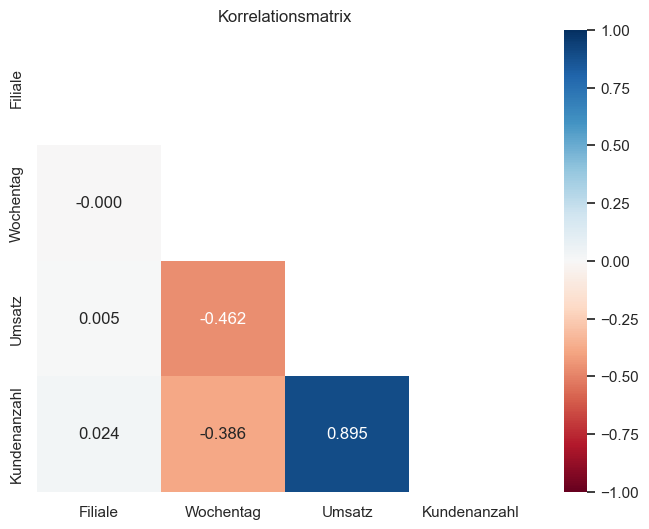

In [213]:
# Spalten mit numerischen Werten
train_only_nr = train.select_dtypes(include=['number'])
corr_matrix = train_only_nr.corr("pearson")
#corr_matrix.style.background_gradient(cmap="Blues", vmin=0, vmax=1)

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(8,6))
plot = sns.heatmap(corr_matrix, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title("Korrelationsmatrix")
plt.show()

In [212]:
#sns.pairplot(train)

## 4. Geeignete Merkmale <a id="4"></a> <br>

Definieren Sie geeignete Merkmale (Features) für die Klassifikation/Regression/Clustering. Versuchen Sie dabei, aus den bestehenden Merkmale neue abzuleiten und überlegen Sie sich zusätzliche z.B. mit externen Informationen. 

## 5. Machine Learning Verfahren 1 <a id="5"></a> <br>

### 5.1 XXX <a id="5.1"></a> <br>

### 5.2 Modellgüte <a id="5.2"></a> <br>

## 6. Machine Learning Verfahren 2 <a id="6"></a> <br>

## 7. Vergleich der Machine Learning Verfahren <a id="7"></a> <br>